In [1]:
import pandas as pd 
import zipfile

### LOADING THE DATA

# zip file containing all data
zip_path = './data.zip'
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    # extract all the contents of the zip file into the current directory
    zip_ref.extractall()


# loading the pressure data file
df_pressure = pd.read_parquet('./data.parquet')
# check if it's loaded correctly
print(df_pressure.head())
print(df_pressure.info())
print(df_pressure.describe())

# loading the labels file
df_labels = pd.read_csv('./labels.csv')
# check if it's loaded correctly
print(df_labels.head())
print(df_labels.describe())

  MachineId  MeasurementId  Pressure
0     0_0_0              0       0.0
1     0_0_0              0       0.0
2     0_0_0              0       0.0
3     0_0_0              0       0.0
4     0_0_0              0       0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      object 
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int64(1), object(1)
memory usage: 422.7+ MB
None
       MeasurementId      Pressure
count   1.846636e+07  1.846636e+07
mean    3.398397e+03  3.338926e-01
std     3.019365e+03  4.862787e-01
min    -1.000000e+00  0.000000e+00
25%    -1.000000e+00  0.000000e+00
50%     3.179000e+03  0.000000e+00
75%     6.277000e+03  7.017707e-01
max     8.834000e+03  6.774464e+00
  MachineId  MeasurementId PumpFailed SlowStart SlowEnd
0     0_0_0              0      False     False   False
1     0_0_1             -1  

In [2]:
### DATA CLEANUP

# encoding MachineId as categorical variable in both tables
df_pressure['MachineId'] = df_pressure['MachineId'].astype('category').cat.codes
df_labels['MachineId'] = df_labels['MachineId'].astype('category').cat.codes
# checking if it was done correctly
print(df_pressure.info())
print(df_labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      int16  
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int16(1), int64(1)
memory usage: 317.0 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27385 entries, 0 to 27384
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MachineId      27385 non-null  int16 
 1   MeasurementId  27385 non-null  int64 
 2   PumpFailed     26900 non-null  object
 3   SlowStart      19300 non-null  object
 4   SlowEnd        19300 non-null  object
dtypes: int16(1), int64(1), object(3)
memory usage: 909.4+ KB
None


In [3]:
### FEATURE ENGINEERING

# function to create features for each measured cycle
def create_features(group):
    half = len(group) // 2
    first_half = group.iloc[:half]
    min_pressure_index = first_half['Pressure'].idxmin()

    # basic statistical features - mean, standard deviation and time to min
    features = {
        'Pressure_mean_first_half': first_half['Pressure'].mean(),
        'Time_to_min_pressure_first_half': min_pressure_index,
        'Pressure_std_first_half': first_half['Pressure'].std(),
    }

    # max pressure drop in the first half
    window_size = 5  
    rolling_max = first_half['Pressure'].rolling(window=window_size).max()
    rolling_min = first_half['Pressure'].rolling(window=window_size).min()
    features['Max_pressure_drop_first_half'] = (rolling_max - rolling_min).max()

    return pd.Series(features)


In [4]:
# aggregate features
df_features = df_pressure.groupby(['MachineId', 'MeasurementId']).apply(create_features).reset_index()

# check results
print(df_features.head())
print(df_labels.head())

# merge the features and labels tables
df_merged = pd.merge(df_features, df_labels, on=['MachineId', 'MeasurementId'], how='inner')

# check results
print(df_merged.head())

   MachineId  MeasurementId  Pressure_mean_first_half  \
0          0             -1                  0.230289   
1          0              0                  0.605873   
2          0            215                  0.710727   
3          0            237                  0.977540   
4          0            353                  0.344599   

   Time_to_min_pressure_first_half  Pressure_std_first_half  \
0                          15396.0                 0.415121   
1                              0.0                 0.582492   
2                         491116.0                 0.729057   
3                         549924.0                 0.706656   
4                         822660.0                 0.390084   

   Max_pressure_drop_first_half  
0                      2.439888  
1                      1.413592  
2                      0.822092  
3                      1.110902  
4                      0.764820  
   MachineId  MeasurementId PumpFailed SlowStart SlowEnd
0          0     

In [5]:
### FURTHER DATA CLEANUP

# remove rows where PumpFailed is NaN
df_cleaned = df_merged.dropna(subset=['PumpFailed']).copy()

# check the cleaned dataframe
print(df_cleaned.dtypes)

# convert PumpFailed to integer
df_cleaned['PumpFailed'] = df_cleaned['PumpFailed'].astype(int)

# check data types
print(df_cleaned.dtypes)
print(df_cleaned['PumpFailed'].unique())

MachineId                            int16
MeasurementId                        int64
Pressure_mean_first_half           float64
Time_to_min_pressure_first_half    float64
Pressure_std_first_half            float64
Max_pressure_drop_first_half       float64
PumpFailed                          object
SlowStart                           object
SlowEnd                             object
dtype: object
MachineId                            int16
MeasurementId                        int64
Pressure_mean_first_half           float64
Time_to_min_pressure_first_half    float64
Pressure_std_first_half            float64
Max_pressure_drop_first_half       float64
PumpFailed                           int64
SlowStart                           object
SlowEnd                             object
dtype: object
[0 1]


In [6]:
# check for missing values in each column
missing_values = df_cleaned.isna().sum()
print(missing_values)

# drop rows where either SlowStart or SlowEnd have missing values
df_cleaned_no_missing = df_cleaned.dropna(subset=['SlowStart', 'SlowEnd']).copy()

# convert SlowStart and SlowEnd to integers
df_cleaned_no_missing['SlowStart'] = df_cleaned_no_missing['SlowStart'].astype(int)
df_cleaned_no_missing['SlowEnd'] = df_cleaned_no_missing['SlowEnd'].astype(int)

# check the result
print(df_cleaned_no_missing.isna().sum())
print(df_cleaned_no_missing.info())

MachineId                             0
MeasurementId                         0
Pressure_mean_first_half              0
Time_to_min_pressure_first_half       0
Pressure_std_first_half               0
Max_pressure_drop_first_half          0
PumpFailed                            0
SlowStart                          7600
SlowEnd                            7600
dtype: int64
MachineId                          0
MeasurementId                      0
Pressure_mean_first_half           0
Time_to_min_pressure_first_half    0
Pressure_std_first_half            0
Max_pressure_drop_first_half       0
PumpFailed                         0
SlowStart                          0
SlowEnd                            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 19300 entries, 1 to 27384
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MachineId                        19300 non-null  

In [9]:
from sklearn.model_selection import train_test_split

### DATA PREPARATION FOR MODELLING

# prepare the data
X = df_cleaned_no_missing[['Pressure_mean_first_half', 'Time_to_min_pressure_first_half', 'Pressure_std_first_half', 'Max_pressure_drop_first_half', 'SlowStart', 'SlowEnd']] # features
y = df_cleaned_no_missing['PumpFailed'] # target

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.ensemble import RandomForestClassifier

### CLASSIFICATION - RANDOM FOREST
# ensemble learning method that operates by constructing multiple decision trees during training 
# output = class that is the mode of the classes of the individual trees
# ability to handle large datasets, robustness against overfitting, effectiveness in dealing with imbalanced classes
# this dataset is imbalanced because in most of the cases PumpFailed is False
# PumpFailed = True is a minority class
# class_weight='balanced' to adjust weights inversely proportional to class frequencies - giving more importance to the PumpFailed = True class
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [11]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

### MODEL EVALUATION

# predictions on the test data
y_pred = model.predict(X_test)

# model evaluation
print('Classification report:')
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
# offers a good balance between precision and recall for the non-failure class
# moderate performance for the failure class
# high overall accuracy and a moderate ROC AUC score

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3444
           1       0.49      0.39      0.43       416

    accuracy                           0.89      3860
   macro avg       0.71      0.67      0.69      3860
weighted avg       0.88      0.89      0.88      3860

Accuracy: 0.8904145077720207
ROC AUC Score: 0.6701761145358706
Confusion Matrix:
[[3275  169]
 [ 254  162]]


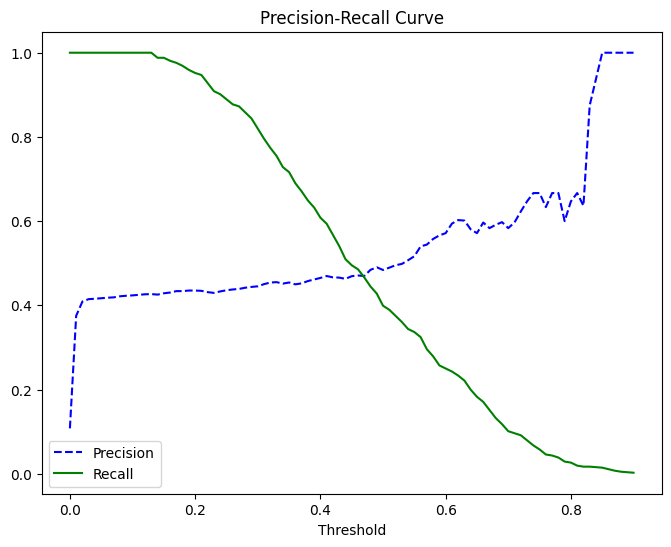

In [13]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

### MODEL IMPROVEMENT
# a lower threshold for classifying a pump failure can make the model more sensitive to failures

# extracting predicted probabilities
y_probs = model.predict_proba(X_test) 

# y_probs is a 2D array with probabilities for class 0 and class 1
# we are interested in the probabilities of class 1
y_probs_class1 = y_probs[:, 1]

# calculate precision and recall for various thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_class1)

# plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.title("Precision-Recall Curve")
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix

# changing the threshold to maximize recall without sacrificing too much precision
threshold = 0.2 

# probabilities to binary predictions based on the new threshold
y_pred_custom_threshold = (y_probs_class1 >= threshold).astype(int)

# re-evaluation of model performance
print('Classification report:')
print(classification_report(y_test, y_pred_custom_threshold))
print("Accuracy:", accuracy_score(y_test, y_pred_custom_threshold))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_custom_threshold))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom_threshold))

# significant improvement in recall for the failure class (at the expense of precision) 
# indicating its strength in identifying most of the actual failures
# good accuracy and a high ROC AUC score

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3444
           1       0.44      0.95      0.60       416

    accuracy                           0.86      3860
   macro avg       0.71      0.90      0.76      3860
weighted avg       0.93      0.86      0.88      3860

Accuracy: 0.8616580310880829
ROC AUC Score: 0.9013390065219333
Confusion Matrix:
[[2930  514]
 [  20  396]]


In [15]:
# extracting the importance of different features
feature_importances = model.feature_importances_
features = X.columns

# looking at them
print(features, feature_importances)
# model relies heavily on Time_to_min_pressure_first_half 
# and less on SlowEnd, Pressure_mean_first_half, Max_pressure_drop_first_half and Pressure_std_first_half
# SlowStart has lower importance

Index(['Pressure_mean_first_half', 'Time_to_min_pressure_first_half',
       'Pressure_std_first_half', 'Max_pressure_drop_first_half', 'SlowStart',
       'SlowEnd'],
      dtype='object') [0.07388672 0.63485031 0.07257654 0.0798937  0.03743831 0.10135443]


In [16]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

### TRYING A PENALIZED SVM CLASSIFIER
# penalized svm - powerful, versatile, and capable of performing linear or nonlinear classification
# strength in high-dimensional spaces, effectiveness in classification tasks with clear margin of separation
# ability to handle imbalanced datasets by penalizing misclassifications of the minority class 

# SVM classifier with balanced class weights
svm_model = SVC(class_weight='balanced', probability=True, random_state=42)

# train the model on the training data
svm_model.fit(X_train, y_train)

### MODEL EVALUATION

# predictions on test data
y_pred = svm_model.predict(X_test)

# evaluating the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# calculating ROC AUC Score
y_probs = svm_model.predict_proba(X_test)[:, 1]  # get probabilities for the positive class
print("ROC AUC Score:", roc_auc_score(y_test, y_probs))

# confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# identifies all failures, but with a very high false positive rate (low precision)
# accuracy is lower, ROC AUC score is good, indicating a decent ability to distinguish between groups

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      3444
           1       0.30      1.00      0.46       416

    accuracy                           0.75      3860
   macro avg       0.65      0.86      0.65      3860
weighted avg       0.92      0.75      0.80      3860

Accuracy: 0.7518134715025907
ROC AUC Score: 0.8609915237201823
Confusion Matrix:
[[2486  958]
 [   0  416]]


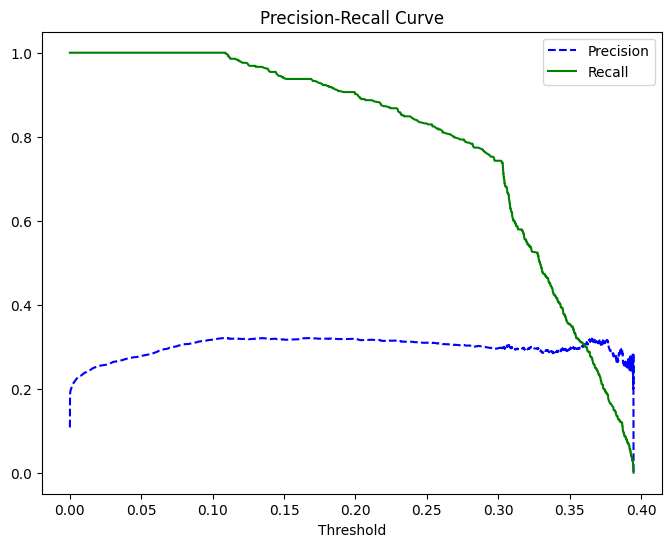

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

### MODEL IMPROVEMENT
# lowering the threshold -> model extremely sensitive to detecting failures

# get predicted probabilities for the test data
y_probs = svm_model.predict_proba(X_test) 

# extracting probabilities for class 1 (failure)
y_probs_class1 = y_probs[:, 1]

# calculate precision and recall for various thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_class1)

# plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.title("Precision-Recall Curve")
plt.show()

In [19]:
# define a custom threshold
# to maximize recall without sacrificing too much precision
threshold = 0.1

# convert probabilities to class predictions based on the threshold
y_pred_custom = (y_probs_class1 >= threshold).astype(int)

# print the classification report for the new predictions
print('Classification report')
print(classification_report(y_test, y_pred_custom))

# accuracy 
print("Accuracy:", accuracy_score(y_test, y_pred_custom))

# confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))

# achieves perfect recall for the failure class but at the cost of many false positives
# slightly improves the recall for the non-failure class compared to the 0.5 threshold model 

Classification report
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      3444
           1       0.32      1.00      0.48       416

    accuracy                           0.77      3860
   macro avg       0.66      0.87      0.67      3860
weighted avg       0.93      0.77      0.81      3860

Accuracy: 0.7678756476683938
Confusion Matrix:
[[2548  896]
 [   0  416]]


In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

### TRYING A K-NEAREST NEIGHBOURS CLASSIFIER
# works by finding the nearest data points in the training set to a given input 
# predicting based on these neighboring points
# straightforward, intuitive, and non-parametric
# reliance on feature similarity could potentially capture the underlying patterns of pump failures

# create a KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)

# train the model on the training data
knn_model.fit(X_train, y_train)

# predict on the test data
y_pred = knn_model.predict(X_test)

# evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# calculate ROC AUC Score
y_probs = knn_model.predict_proba(X_test)[:, 1]  # probabilities for the positive class
print("ROC AUC Score:", roc_auc_score(y_test, y_probs))

# confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# moderate precision and recall for both classes
# good accuracy and a high ROC AUC score
# isn't strong in detecting pump failures

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      3444
           1       0.44      0.31      0.36       416

    accuracy                           0.88      3860
   macro avg       0.68      0.63      0.65      3860
weighted avg       0.87      0.88      0.87      3860

Accuracy: 0.8823834196891192
ROC AUC Score: 0.828952456334316
Confusion Matrix:
[[3276  168]
 [ 286  130]]


In [21]:
from sklearn.preprocessing import StandardScaler

### TRYING SCALING THE FEATURES FOR KNN
# scaling the data helps KNN perform better
# it ensures that the distance metric is not influenced by features on larger scales

# scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create and train KNN on the scaled data
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# predict
y_pred = knn_model.predict(X_test_scaled)

# evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# ROC AUC score
y_probs = knn_model.predict_proba(X_test_scaled)[:, 1]  # probabilities for the positive class
print("ROC AUC Score:", roc_auc_score(y_test, y_probs))

# confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# improved performance compared to KNN on unscaled data, especially in ROC AUC score
# slightly better capability in identifying failures

### CONCLUSION
# Each model has its strengths and weaknesses. 
# The trade-off between recall (catching as many true failures as possible) and precision 
# (reducing false alarms) is in my opinion the trickiest part about this imbalanced dataset. 
# The choice of the best model depends on the specific requirements.
# Especially on the relative importance of missing actual failures versus incorrect failure alarms.
# If given more time, I would first dive deeper into advanced feature engineering, exploring ways 
# to better capture the pump failure patterns. 
# Then I'd try ensemble methods like Gradient Boosting or neural networks.

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      3444
           1       0.46      0.44      0.45       416

    accuracy                           0.88      3860
   macro avg       0.70      0.69      0.69      3860
weighted avg       0.88      0.88      0.88      3860

Accuracy: 0.8836787564766839
ROC AUC Score: 0.890072897123202
Confusion Matrix:
[[3229  215]
 [ 234  182]]
